# DBS-EEG-LFP Complete Preprocessing Pipeline

This notebook demonstrates the **complete pipeline** for processing and synchronizing DBS stimulation data from EEG and LFP recordings.

## Pipeline Steps:
1. Load LFP data
2. Load EEG data  
3. Create LFP stimulation time series
4. **Complete EEG-LFP synchronization with artifact removal**
5. Export to BIDS format
6. Visualization and validation

## System Setup

In [ ]:
%gui qt

import mne
mne.viz.set_browser_backend('qt')
mne.viz.set_3d_backend('pyvistaqt')

Using qt as 2D backend.
Using pyvistaqt 3d backend.


Channels marked as bad:
none
Channels marked as bad:
none
Channels marked as bad:
none


In [2]:
from pathlib import Path
import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

project_root = Path(os.getcwd())
print(f"Current working directory: {project_root}")
sys.path.append('/workspace/src')   # Add src directory to path

from preprocessing import lfp_io, eeg_io, bids_export, visualization, alignment

print("✓ Modules loaded successfully")

Current working directory: /workspace
✓ Modules loaded successfully


## 1. Configuration

In [3]:

# Define paths (use relative paths)

# ---- Base directories ----
DATA_ROOT = project_root / "shared" / "data" / "raw"
RESULTS_ROOT = project_root / "shared" / "results"
BIDS_ROOT = project_root / "shared" / "data" / "bids_dataset"

# ---- Subject information ----
SUBJECT_NAME = "Roessner_Gerhard"
STIM_FREQ = 55  # Hz

subject_id = "001"
session_id = "01"
task_name = "StimOn55HzFull2"
diagnosis = "PD"

# ---- Input files ----
LFP_FILE = DATA_ROOT / SUBJECT_NAME / "lfp" / "brainsense_55Hz_2iter.json"
EEG_FILE = DATA_ROOT / SUBJECT_NAME / "eeg" / "Stim_On_55Hz_Full2.mff"
# HEAD_MODEL = DATA_ROOT / SUBJECT_NAME / "headmodel_ROESSNER.mat"
# COORD_XML = EEG_FILE.parent / "coordinates.xml"

# ---- Ensure output directories exist ----
RESULTS_ROOT.mkdir(parents=True, exist_ok=True)
BIDS_ROOT.mkdir(parents=True, exist_ok=True)

# ---- Print summary ----
print(f"Project root: {project_root}")
print(f"Data root: {DATA_ROOT}")
print(f"Results root: {RESULTS_ROOT}")
print(f"BIDS root: {BIDS_ROOT}")
# print(f"Head Model file: {HEAD_MODEL}")
# print(f"EEG Coordinates file: {COORD_XML}")



Project root: /workspace
Data root: /workspace/shared/data/raw
Results root: /workspace/shared/results
BIDS root: /workspace/shared/data/bids_dataset


## 2. Load and Process LFP Data

In [4]:
# Load LFP data
print("Loading LFP data...")
df_ts_sense, df_ts_stim, df_settings = lfp_io.load_lfp_data(LFP_FILE)

print(f"\nLFP Sensing data shape: {df_ts_sense.shape}")
print(f"LFP Stimulation data shape: {df_ts_stim.shape}")
print(f"\nSettings:")
df_settings

Loading LFP data...

LFP Sensing data shape: (29687, 2)
LFP Stimulation data shape: (236, 2)

Settings:


,subj_id,left_sr,left_ch,left_stim_contact,right_sr,right_ch,right_stim_contact
0,Roessner_Gerhard,250,+3-0,1,250,+3-0,1


In [5]:
if 'preprocessing.lfp_io' in sys.modules:
    del sys.modules['preprocessing.lfp_io']
    import preprocessing.lfp_io as lfp_io
 

In [6]:
# Align stimulation data to sensing timeline
print("Aligning LFP stimulation data...")
df_ts_stim_aligned = lfp_io.align_stim_to_sense(df_ts_stim, df_ts_sense)

print(f"Aligned stimulation data shape: {df_ts_stim_aligned.shape}")
print(f"Duration: {(df_ts_sense.index[-1] - df_ts_sense.index[0]).total_seconds():.1f} seconds")

Aligning LFP stimulation data...
Aligned stimulation data shape: (29687, 2)
Duration: 118.7 seconds


In [7]:
df_ts_stim

,stim_amp_left,stim_amp_right
2024-02-14 09:43:30.750,3.0,3.5
2024-02-14 09:43:31.250,3.0,3.5
2024-02-14 09:43:31.750,3.0,3.5
2024-02-14 09:43:32.250,3.0,3.5
2024-02-14 09:43:32.750,3.0,3.5
...,...,...
2024-02-14 09:45:26.250,3.0,3.5
2024-02-14 09:45:26.750,3.0,3.5
2024-02-14 09:45:27.250,3.0,3.5
2024-02-14 09:45:27.750,3.0,3.5


In [8]:
df_ts_sense, df_ts_stim_aligned

(                         voltage_left  voltage_right
 2024-02-14 09:43:30.500    -18.789058      77.251617
 2024-02-14 09:43:30.504     10.328488      -8.387318
 2024-02-14 09:43:30.508     24.502690     -46.682049
 2024-02-14 09:43:30.512     -5.603754      13.574213
 2024-02-14 09:43:30.516    -31.644730      65.443155
 ...                               ...            ...
 2024-02-14 09:45:29.228      0.988898      -3.421143
 2024-02-14 09:45:29.232     22.085384     -63.235966
 2024-02-14 09:45:29.236     -1.318530     -12.360259
 2024-02-14 09:45:29.240    -42.632483      38.074011
 2024-02-14 09:45:29.244    -14.613712      51.537864
 
 [29687 rows x 2 columns],
                          stim_amp_left  stim_amp_right
 2024-02-14 09:43:30.500            3.0             3.5
 2024-02-14 09:43:30.504            3.0             3.5
 2024-02-14 09:43:30.508            3.0             3.5
 2024-02-14 09:43:30.512            3.0             3.5
 2024-02-14 09:43:30.516            3.0    

In [9]:
df_combined = df_ts_sense.join(df_ts_stim_aligned, how='left')
df_combined

,voltage_left,voltage_right,stim_amp_left,stim_amp_right
2024-02-14 09:43:30.500,-18.789058,77.251617,3.0,3.5
2024-02-14 09:43:30.504,10.328488,-8.387318,3.0,3.5
2024-02-14 09:43:30.508,24.502690,-46.682049,3.0,3.5
2024-02-14 09:43:30.512,-5.603754,13.574213,3.0,3.5
2024-02-14 09:43:30.516,-31.644730,65.443155,3.0,3.5
...,...,...,...,...
2024-02-14 09:45:29.228,0.988898,-3.421143,3.0,3.5
2024-02-14 09:45:29.232,22.085384,-63.235966,3.0,3.5
2024-02-14 09:45:29.236,-1.318530,-12.360259,3.0,3.5
2024-02-14 09:45:29.240,-42.632483,38.074011,3.0,3.5


In [10]:
lfp_data= df_combined[['voltage_left', 'voltage_right',
                       'stim_amp_left', 'stim_amp_right']].to_numpy().T  # shape: (n_ch, n_times)

# Extract sampling rate
lfp_sfreq = float(df_settings['left_sr'].iloc[0])

# Create channel info
ch_names = ['LFP_L', 'LFP_R', 'STIM_L', 'STIM_R']
ch_types = ['seeg', 'seeg', 'stim', 'stim']
info_lfp = mne.create_info(ch_names=ch_names, sfreq=lfp_sfreq, ch_types=ch_types)

# Create Raw object
raw_lfp = mne.io.RawArray(lfp_data, info_lfp)

print(f"\n✓ Full LFP Raw object created:")
print(f"  Duration: {raw_lfp.times[-1]:.2f}s")
print(f"  Channels: {raw_lfp.info['nchan']}")
print(f"  Sampling rate: {raw_lfp.info['sfreq']:.1f} Hz")

Creating RawArray with float64 data, n_channels=4, n_times=29687
    Range : 0 ... 29686 =      0.000 ...   118.744 secs
Ready.

✓ Full LFP Raw object created:


  Duration: 118.74s
  Channels: 4
  Sampling rate: 250.0 Hz


In [11]:
# Prepare LFP stimulation time series for synchronization
print("Preparing LFP stimulation time series...")

# Create DataFrame with timestamp and stim_on columns
# Using left hemisphere as reference (can also use right or both)
df_stim_for_sync = pd.DataFrame({
    'timestamp': raw_lfp.times,  # Time in seconds from start
    'stim_on': df_ts_stim_aligned['stim_amp_left'].values > 0  # Boolean: stim is ON
})

print(f"\nStimulation time series shape: {df_stim_for_sync.shape}")
print(f"Stim ON samples: {df_stim_for_sync['stim_on'].sum()}")
print(f"Stim OFF samples: {(~df_stim_for_sync['stim_on']).sum()}")

Preparing LFP stimulation time series...

Stimulation time series shape: (29687, 2)
Stim ON samples: 28687
Stim OFF samples: 1000


In [12]:
# Extract middle segment for analysis
print("Extracting middle stimulation segment...")

df_left_middle, left_info = lfp_io.extract_middle_segment(
    df_ts_sense, 
    df_ts_stim_aligned, 
    side='left',
    start_buffer_sec=0,  
    end_buffer_sec=0     
)

if left_info:
    print(f"\nLeft hemisphere middle segment:")
    print(f"  Duration: {left_info['duration_sec']:.2f} seconds")
    print(f"  Samples: {left_info['n_samples']}")
    print(f"  Stim amplitude: {left_info['stim_amplitude']} mA")
    
    LFP_SEGMENT_DURATION = left_info['duration_sec']
else:
    print("Warning: Could not extract StimOn segment")


Extracting middle stimulation segment...
Removed 379 samples containing artifacts

Left hemisphere middle segment:
  Duration: 94.98 seconds
  Samples: 23746
  Stim amplitude: 3.0 mA


## 3. Load EEG Data

In [13]:
# Load EEG data
print("Loading full EEG data...")
raw_eeg = eeg_io.load_eeg_data(EEG_FILE, preload=True)

print(f"\n✓ Full EEG Raw object loaded:")
print(f"  Duration: {raw_eeg.times[-1]:.2f}s")
print(f"  Channels: {raw_eeg.info['nchan']}")
print(f"  Sampling rate: {raw_eeg.info['sfreq']:.1f} Hz")
raw_eeg.info

Loading full EEG data...
Reading EGI MFF Header from /workspace/shared/data/raw/Roessner_Gerhard/eeg/Stim_On_55Hz_Full2.mff...
    Reading events ...
    Assembling measurement info ...
    Excluding events {} ...
Reading 0 ... 56944  =      0.000 ...   113.888 secs...

✓ Full EEG Raw object loaded:
  Duration: 113.89s
  Channels: 281
  Sampling rate: 500.0 Hz


<Info | 10 non-empty values
 bads: []
 ch_names: 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, ...
 chs: 281 EEG
 custom_ref_applied: False
 device_info: 1 item (dict)
 dig: 284 items (3 Cardinal, 281 EEG)
 highpass: 0.0 Hz
 lowpass: 250.0 Hz
 meas_date: 2023-11-04 04:28:41 UTC
 nchan: 281
 projs: []
 sfreq: 500.0 Hz
 utc_offset: +0000
>

In [14]:
# Setup reference channels
# print("Setting up reference channels...")
# raw = eeg_io.setup_reference_channels(raw)

# Detect stimulation frequency
# print("\nDetecting stimulation frequency...")
# detected_freq, freqs, psd = eeg_io.detect_stim_frequency(raw_eeg, freq_range=(40, 70))

# print(f"Detected frequency: {detected_freq:.2f} Hz")
# print(f"Expected frequency: {STIM_FREQ} Hz")

In [15]:
# fig = raw_eeg.plot(start=2, duration=6)
# fig.fake_keypress("a")
# print(raw_eeg.annotations)
# print("onset:", raw_eeg.annotations.onset)
# print("duration:", raw_eeg.annotations.duration)
# print("description:", raw_eeg.annotations.description)



In [16]:
fig = raw_lfp.plot(start=2, duration=6)
# print(raw_lfp.annotations)
# print("onset:", raw_lfp.annotations.onset)
# print("duration:", raw_lfp.annotations.duration)
# print("description:", raw_lfp.annotations.description)

## 4. Complete EEG-LFP Synchronization 

### Steps:
1. Detects all STIM_ON/STIM_OFF events from LFP
2. Identifies the middle long stim-on segment as anchor
3. Synchronizes EEG with LFP using this anchor
4. Maps all LFP events to EEG time axis
5. Adds unified event labels to both signals


In [17]:
# Execute complete synchronization WITH artifact removal 
print("EXECUTING COMPLETE EEG-LFP SYNCHRONIZATION")
print("\nConfiguration:")
print(f"  Stimulation frequency: {STIM_FREQ} Hz")
print(f"  Middle segment ID: 1 (second stim-on segment)")
print(f"  Artifact removal: ENABLED ")
print(f"  Artifact threshold: 5.0 std")
print(f"  Detection channel: LFP_L")

sync_results = alignment.complete_eeg_lfp_synchronization(
    raw_eeg=raw_eeg,
    raw_lfp=raw_lfp,
    df_stim=df_stim_for_sync,
    stim_freq=STIM_FREQ,
    middle_segment_id=1,  # Use second stim-on segment as anchor
    stim_column='stim_on',
    time_column='timestamp',
    remove_artifacts=True,          # Enable artifact removal
    artifact_threshold_std=5.0,     # Threshold
    lfp_channel='LFP_L'             # Detection channel
)

print("\n✓ Synchronization complete!")

EXECUTING COMPLETE EEG-LFP SYNCHRONIZATION

Configuration:
  Stimulation frequency: 55 Hz
  Middle segment ID: 1 (second stim-on segment)
  Artifact removal: ENABLED 
  Artifact threshold: 5.0 std
  Detection channel: LFP_L

                    COMPLETE EEG-LFP SYNCHRONIZATION

STEP 1: Extract events from LFP stimulation time series
--------------------------------------------------------------------------------

DETECTING STIMULATION EVENTS FROM LFP

Found 3 STIM_ON events
Found 3 STIM_OFF events

----------------------------------------------------------------------
EVENT SUMMARY:
----------------------------------------------------------------------
  Event 0: STIM_ON    at     0.00s (segment 0)
  Event 1: STIM_OFF   at     4.50s (segment 0)
  Event 2: STIM_ON    at     6.50s (segment 1)
  Event 3: STIM_OFF   at   103.00s (segment 1)
  Event 4: STIM_ON    at   105.00s (segment 2)
  Event 5: STIM_OFF   at   118.74s (segment 2)

✓ DETECTED 6 TOTAL EVENTS

STEP 2: Identify stimulation 

In [18]:
# 手动标记stim_off_segmen_1和stim_off_segmen_2 作为 eeg baseline
raw_eeg_synced = sync_results['raw_eeg']
eeg_events = sync_results['eeg_events']
raw_eeg_synced.plot(events=eeg_events, event_color='red')

In [19]:
print(raw_eeg_synced.annotations)
print("onset:", raw_eeg_synced.annotations.onset)
print("duration:", raw_eeg_synced.annotations.duration)
print("description:", raw_eeg_synced.annotations.description)

<Annotations | 5 segments: synced/STIM_OFF (2), synced/STIM_ON (3)>
onset: [  2.118   6.614   8.618 105.114 107.118]
duration: [0. 0. 0. 0. 0.]
description: ['synced/STIM_ON' 'synced/STIM_OFF' 'synced/STIM_ON' 'synced/STIM_OFF'
 'synced/STIM_ON']


In [20]:
# Extract synchronized data
raw_eeg_synced = sync_results['raw_eeg']
raw_lfp_synced = sync_results['raw_lfp']
eeg_events = sync_results['eeg_events']
event_id = sync_results['event_id']
sync_info = sync_results['sync_info']
sync_anchor = sync_results['sync_anchor']
artifact_info = sync_results.get('artifact_info')


print("\nSynchronization results extracted:")
print(f"  raw_eeg_synced: {raw_eeg_synced.times[-1]:.2f}s, {raw_eeg_synced.info['nchan']} channels")
print(f"  raw_lfp_synced: {raw_lfp_synced.times[-1]:.2f}s, {raw_lfp_synced.info['nchan']} channels")
print(f"  Events mapped: {len(eeg_events)}")
print(f"  Event types: {list(event_id.keys())}")

if artifact_info:
    print(f"\nArtifact removal info:")
    print(f"  Samples removed: {artifact_info['n_samples_removed']}")
    print(f"  Time removed: {artifact_info['time_removed_sec']:.2f}s")
    print(f"  Original start: {artifact_info['original_start']:.2f}s")
    print(f"  New start: {artifact_info['new_start']:.2f}s")
    print(f"  New stim_on duration: {artifact_info['new_duration']:.2f}s")



Synchronization results extracted:
  raw_eeg_synced: 113.89s, 281 channels
  raw_lfp_synced: 118.74s, 4 channels
  Events mapped: 5
  Event types: ['STIM_ON', 'STIM_OFF']

Artifact removal info:
  Samples removed: 379
  Time removed: 1.52s
  Original start: 6.50s
  New start: 8.02s
  New stim_on duration: 94.98s


In [21]:
# 手动标记stim_off_segmen_1和stim_off_segmen_2 作为 eeg baseline
raw_eeg_synced.plot(events=eeg_events, event_color='red')
print(raw_eeg_synced.annotations)
print("onset:", raw_eeg_synced.annotations.onset)
print("duration:", raw_eeg_synced.annotations.duration)
print("description:", raw_eeg_synced.annotations.description)

<Annotations | 5 segments: synced/STIM_OFF (2), synced/STIM_ON (3)>
onset: [  2.118   6.614   8.618 105.114 107.118]
duration: [0. 0. 0. 0. 0.]
description: ['synced/STIM_ON' 'synced/STIM_OFF' 'synced/STIM_ON' 'synced/STIM_OFF'
 'synced/STIM_ON']


In [22]:
# Export synchronized data to BIDS
print("\nExporting synchronized data to BIDS format...")

# 转换LFP为DataFrame
lfp_data = raw_lfp_synced.get_data()
lfp_times = raw_lfp_synced.times

df_lfp_for_bids = pd.DataFrame({
    'voltage_left': lfp_data[0],   
    'voltage_right': lfp_data[1],   
}, index=pd.to_timedelta(lfp_times, unit='s'))

df_stim_for_bids = pd.DataFrame({
    'stim_amp_left': lfp_data[2],   
    'stim_amp_right': lfp_data[3],  
}, index=pd.to_timedelta(lfp_times, unit='s'))

print(f"  ✓ EEG: {raw_eeg_synced.times[-1]:.2f}s, {len(raw_eeg_synced.annotations)} events")
print(f"  LFP: {raw_lfp_synced.times[-1]:.2f}s, {len(raw_lfp_synced.annotations)} events")
print(f"  ✓ DataFrame列名: {list(df_lfp_for_bids.columns)}, {list(df_stim_for_bids.columns)}")


bids_root = bids_export.export_to_bids(
    eeg_segment=raw_eeg_synced,
    df_lfp_sense=df_lfp_for_bids,
    df_stim_aligned=df_stim_for_bids,
    df_settings=df_settings,
    subject_id=subject_id,
    session=session_id,
    task=task_name,
    bids_root=BIDS_ROOT,
    stim_freq=STIM_FREQ,
    diagnosis=diagnosis,
    save_lfp_fif=True,
    save_lfp_tsv=True
)

print(f"\n{'='*70}")
print("✓ BIDS export complete!")
print(f"{'='*70}")
print(f"BIDS root: {bids_root}")
print(f"\n Saved data:")
print(f"  ✓ EEG: {raw_eeg_synced.times[-1]:.2f}s, {len(raw_eeg_synced.annotations)} events")
print(f"  ✓ LFP: {raw_lfp_synced.times[-1]:.2f}s, {len(raw_lfp_synced.annotations)} events")


Exporting synchronized data to BIDS format...
  ✓ EEG: 113.89s, 5 events
  LFP: 118.74s, 6 events
  ✓ DataFrame列名: ['voltage_left', 'voltage_right'], ['stim_amp_left', 'stim_amp_right']

CREATING BIDS DATASET WITH DERIVATIVES

[STEP 1] Creating BIDS directory structure...
    OK Raw BIDS structure
    OK Derivatives structure

[STEP 2] Creating dataset-level metadata...
OK Dataset description: dataset_description.json
OK Derivatives description: derivatives/mne-python/dataset_description.json
OK Participants files: participants.tsv, participants.json

[STEP 3] Saving EEG data...

SAVING EEG DATA IN BIDS FORMAT

[1] Checking digitization information...
    Digitization points: 284
      - Fiducials: 3
      - EEG: 281

[2] Writing EEG data (BrainVision format - BIDS standard)...


/opt/conda/envs/inf/lib/python3.10/site-packages/mne_bids/write.py:1403: UserWarning: Conflicting BIDSVersion found in dataset_description.json! Consider setting BIDS root to a new directory and redo conversion after ensuring all software has been updated. Original dataset description will not be overwritten.
  warnings.warn(
/workspace/src/preprocessing/bids_export.py:143: RuntimeWarning: Converting data files to BrainVision format
  write_raw_bids(


    OK EEG data saved to: sub-001/ses-01/eeg

[3] Saving FIF format in derivatives...
    OK Saved FIF: derivatives/mne-python/sub-001/ses-01/eeg/sub-001_ses-01_task-StimOn55HzFull2_eeg.fif
    OK Digitization preserved: 284 points
    OK Saved README: README.txt

[4] Verifying BIDS files...
    OK BrainVision preserved all digitization: 284 points

[5] Adding custom metadata...
    OK Metadata updated

[STEP 4] Saving LFP data...

SAVING LFP DATA IN BIDS FORMAT (iEEG)

[1] Preparing LFP data arrays...
    OK Data shape: 29687 samples
    OK Sampling rate: 250.0 Hz
    OK Duration: 118.74 seconds

[2] Writing LFP data as MNE FIF format (derivatives)...
Creating RawArray with float64 data, n_channels=4, n_times=29687
    Range : 0 ... 29686 =      0.000 ...   118.744 secs
Ready.
    OK Saved FIF: derivatives/mne-python/sub-001/ses-01/ieeg/sub-001_ses-01_task-StimOn55HzFull2_ieeg.fif
    OK Format: MNE-Python FIF (binary, efficient)
    OK Channels: 4
    OK Ready for preprocessing pipel

/workspace/src/preprocessing/bids_export.py:198: RuntimeWarning: Unable to map the following column(s) to to MNE:
diagnosis: PD
  raw_reloaded = read_raw_bids(bids_path, verbose=False)


    OK Saved TSV: sub-001/ses-01/ieeg/sub-001_ses-01_task-StimOn55HzFull2_ieeg.tsv
    OK Format: TSV (text, human-readable)

[4] Writing metadata...
    OK Saved: sub-001_ses-01_task-StimOn55HzFull2_ieeg.json

[5] Writing channel information...
    OK Saved: sub-001_ses-01_task-StimOn55HzFull2_channels.tsv

[6] Writing stimulation events...
    OK Saved: sub-001_ses-01_task-StimOn55HzFull2_events.tsv

>> LFP data export complete!

SUCCESS - BIDS DATASET CREATED

Dataset location: /workspace/shared/data/bids_dataset

Structure:
  bids_dataset/
  ├── sub-001/ses-01/
  │   ├── eeg/     (BrainVision format)
  │   └── ieeg/    (TSV format + metadata)
  └── derivatives/mne-python/sub-001/ses-01/
      ├── eeg/     (FIF format with digitization)
      └── ieeg/    (FIF format for preprocessing)

>> FIF files ready for MNE-Python preprocessing pipeline
>> TSV files available for human inspection

>> Dataset is BIDS-compliant and ready for analysis!

✓ BIDS export complete!
BIDS root: /workspa

## 5. Verify Synchronization Quality

In [23]:
alignment.print_synchronization_report(sync_results)


                         SYNCHRONIZATION REPORT

RECORDINGS:
--------------------------------------------------------------------------------
EEG:
  Duration:      113.89s
  Sampling rate: 500.0 Hz
  N channels:    281

LFP:
  Duration:      118.74s
  Sampling rate: 250.0 Hz
  N channels:    4

STIMULATION SEGMENTS:
--------------------------------------------------------------------------------
Segment 0 (stim_on   ):    0.00s -    4.50s (duration:   4.50s)
Segment 1 (stim_off  ):    4.50s -    6.50s (duration:   2.00s)
Segment 2 (stim_on   ):    6.50s -  103.00s (duration:  96.50s)
Segment 3 (stim_off  ):  103.00s -  105.00s (duration:   2.00s)
Segment 4 (stim_on   ):  105.00s -  118.74s (duration:  13.74s)

SYNCHRONIZATION:
--------------------------------------------------------------------------------
Anchor segment: 1
  LFP time: 8.02s
  EEG time: 10.13s
  Offset:   2.12s

Artifact removal:
  Samples removed: 379
  Time removed:    1.52s
  Original start:  6.50s
  New start:    

✓ Figure saved: /workspace/shared/results/lfp_timeseries.png


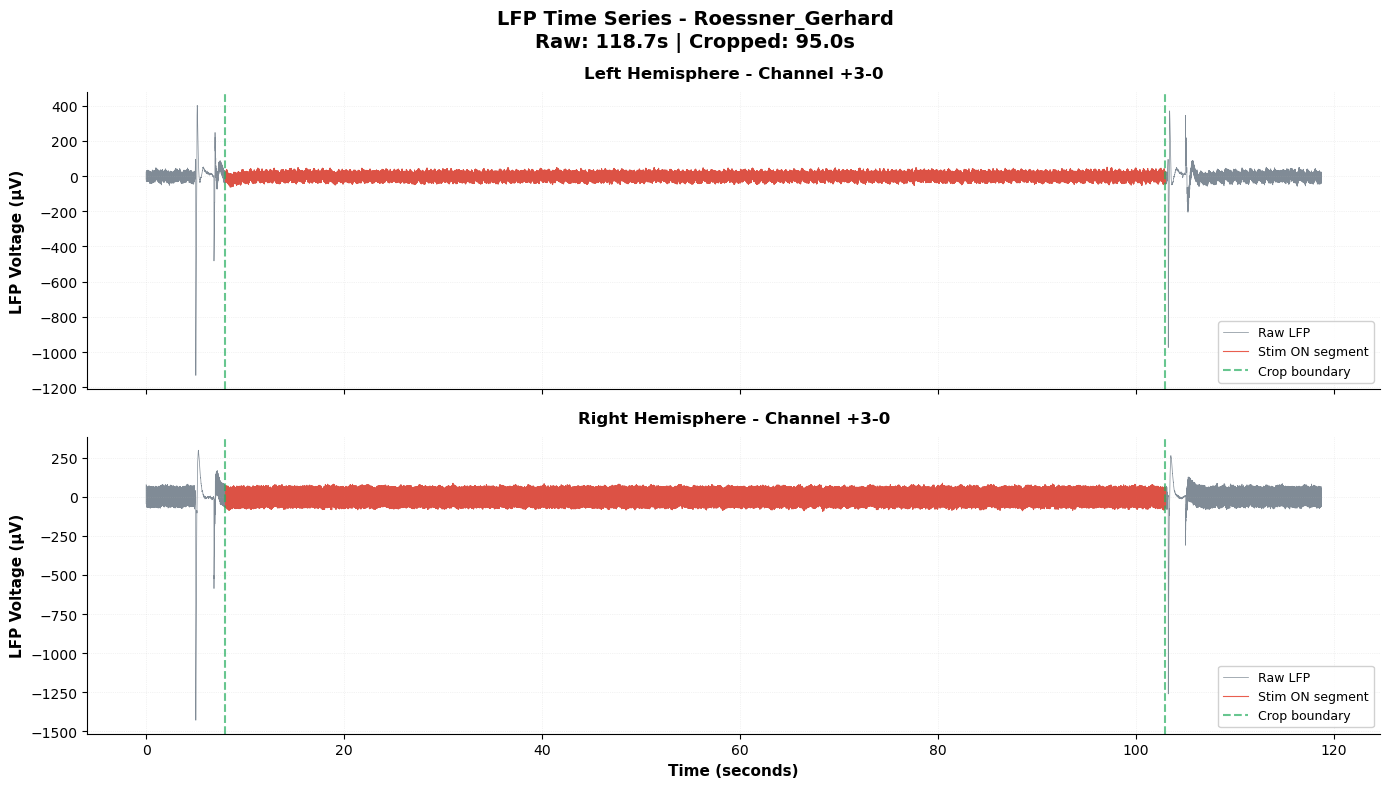

In [24]:
# from preprocessing import visualization

# LFP时间序列（显示原始+裁剪段）
fig = visualization.plot_lfp_timeseries(
    df_ts_sense=df_ts_sense,       # 完整原始数据
    df_ts_cropped=df_left_middle,  # 裁剪后的数据
    df_settings=df_settings,
    save_path=RESULTS_ROOT / 'lfp_timeseries.png'
)
plt.show()

✓ Figure saved: eeg_comparison.png


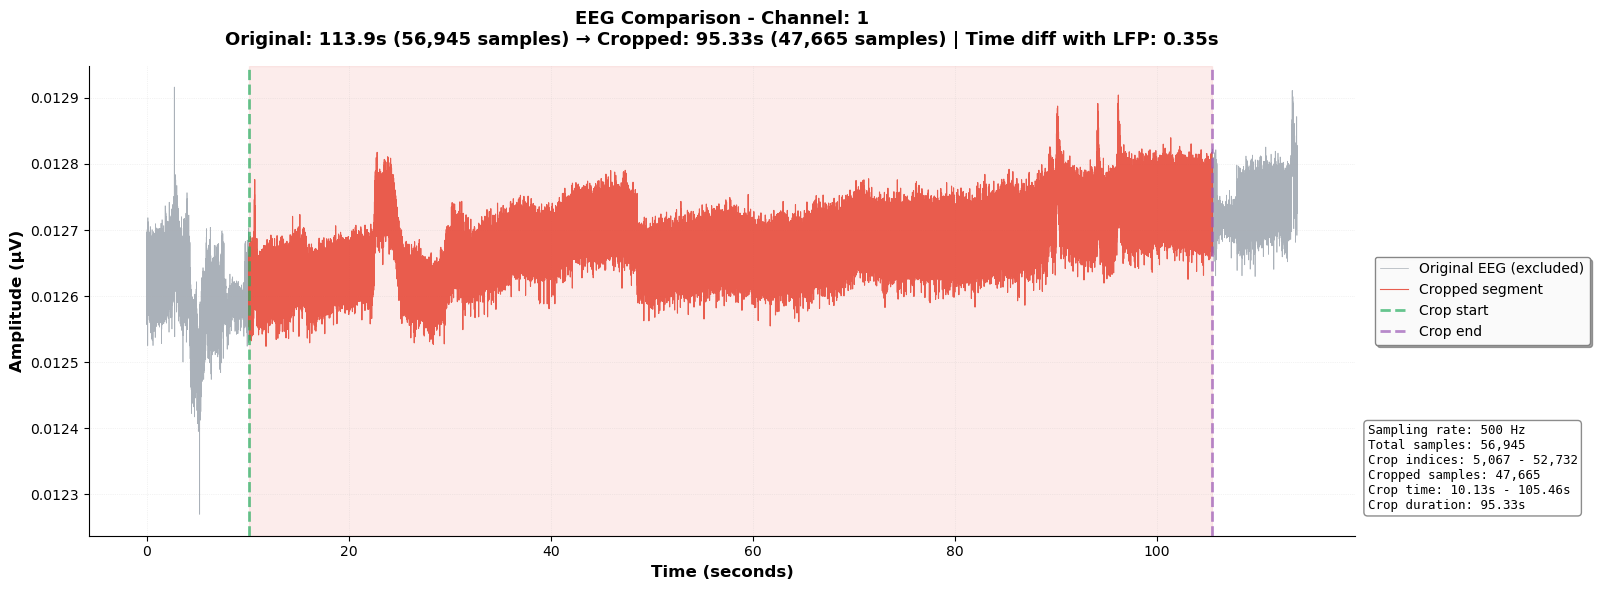

In [25]:
# 计算索引
eeg_start_time = sync_info.get('eeg_start')
eeg_end_time = sync_info.get('eeg_end')
sfreq = raw_eeg_synced.info['sfreq']

crop_start_idx = int(eeg_start_time * sfreq)
crop_end_idx = int(eeg_end_time * sfreq)

# 调用可视化
fig = visualization.plot_eeg_comparison(
    raw_eeg=raw_eeg_synced,
    crop_start_idx=crop_start_idx,
    crop_end_idx=crop_end_idx,
    channel_idx=0,
    sync_info=sync_info,
    save_path='eeg_comparison.png'
)

✓ Figure saved: /workspace/shared/results/stimulation_amplitudes.png


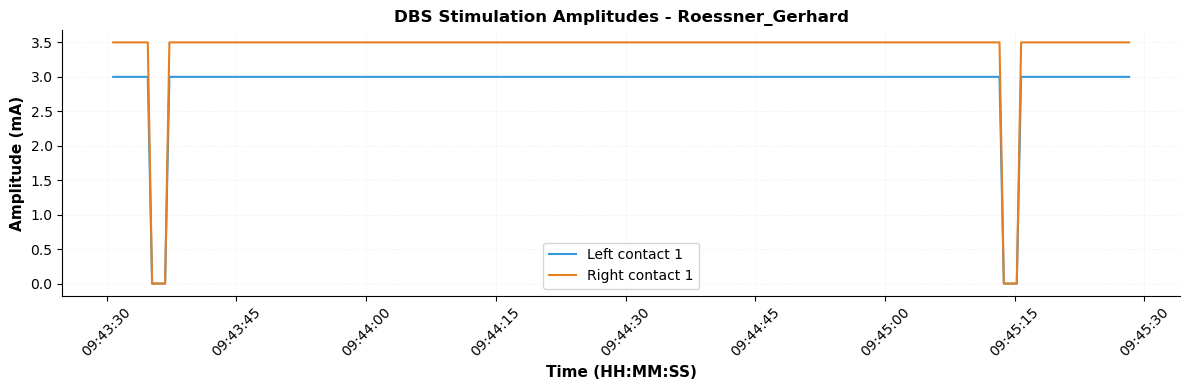

In [26]:
# Plot stimulation amplitudes
fig = visualization.plot_stimulation_amplitudes(
    df_ts_stim,
    df_settings,
    save_path=RESULTS_ROOT / 'stimulation_amplitudes.png'
)
plt.show()

✓ Figure saved: /workspace/shared/results/synchronization_result.png


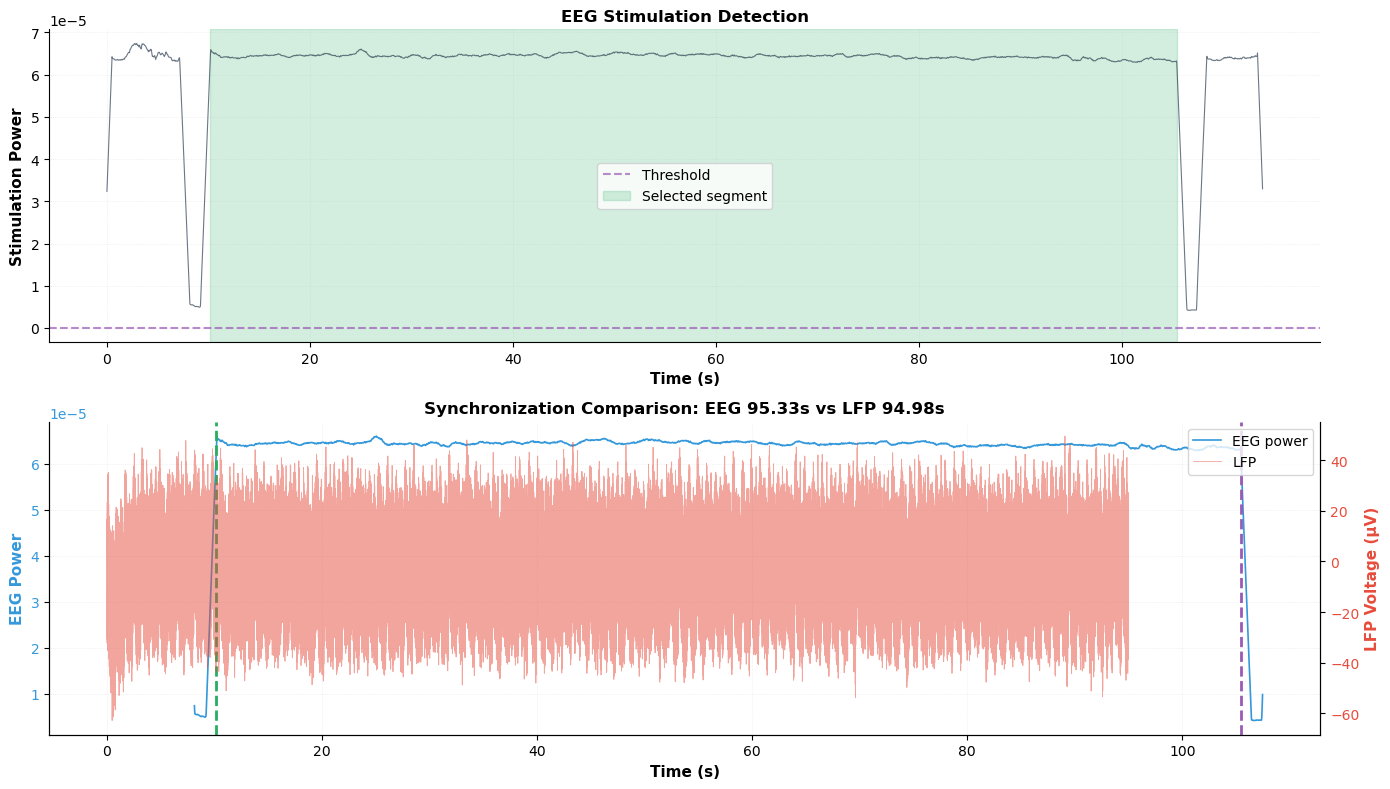

In [27]:
# Plot synchronization result
if sync_info is not None:
    fig = visualization.plot_synchronization_result(
        sync_info,
        df_lfp=df_left_middle if df_left_middle is not None else df_ts_sense,
        save_path=RESULTS_ROOT / 'synchronization_result.png'
    )
    plt.show()

Computing power spectral density...
✓ Figure saved: /workspace/shared/results/lfp_psd.png


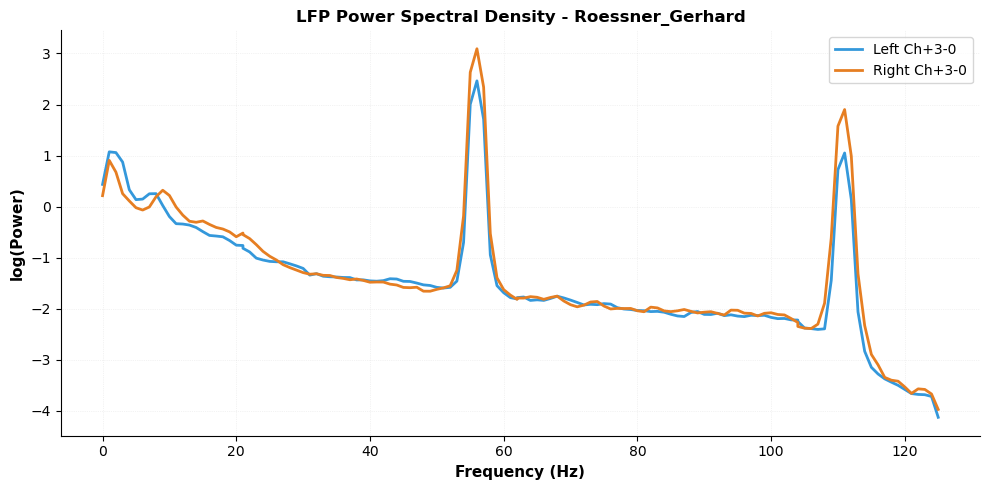

In [28]:
# Compute PSD for LFP
print("Computing power spectral density...")
df_psd = lfp_io.compute_psd(
    df_left_middle if df_left_middle is not None else df_ts_sense,
    df_settings
)

# Plot PSD
fig = visualization.plot_lfp_psd(
    df_psd,
    df_settings,
    save_path=RESULTS_ROOT / 'lfp_psd.png'
)
plt.show()